In [1]:
#############################################################################
# IMPORTS AND SETUP
#############################################################################
# Set random seed for reproducibility
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True  # Makes training more deterministic
torch.backends.cudnn.benchmark = False     # Can speed up training when input sizes don't change

# Standard imports
import pandas as pd
import numpy as np
import polars as pl
from datetime import datetime, timedelta
import time
import os

from tqdm.auto import tqdm  # Progress bar

# PyEPO imports
from pyepo.data.dataset import optDataset
import pyepo

# Check and set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    # Clear GPU cache to maximize available memory
    torch.cuda.empty_cache()



# ##### 强制使用CPU
# # os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# device = torch.device("cpu")
# # Force JAX to use the CPU backend only (avoids CUDA OOM in JAX)
# os.environ['JAX_PLATFORMS'] = 'cpu'

/home/yuheng/.venv_AI/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA H100 80GB HBM3


# Training and Testing


## 随机生成横截面xy数据

In [2]:
# Setting parameters
k = 5  # number of x features
m = 3  # number of y features
symbols = ['aaa', 'bbb', 'ccc', 'ddd', 'eee', 'fff', 'ggg', 'hhh', 'iii', 'jjj']  # 10 symbols

# Generate time range: minutes from 2025-04-01 to 2025-04-09
start_time = datetime(2025, 4, 1)
end_time = datetime(2025, 4, 1, 1, 59)
minutes_diff = int((end_time - start_time).total_seconds() / 60) + 1
time_range = [start_time + timedelta(minutes=i) for i in range(minutes_diff)]

# Create empty dataframe with desired columns
columns = ['time', 'symbol'] + [f'x{i+1}' for i in range(k)] + [f'y{i+1}' for i in range(m)]
data = []

# Generate random data
for time in time_range:
    for symbol in symbols:
        # Generate white noise for each x and y
        x_values = np.random.normal(0, 1, k)
        y_values = np.random.normal(0, 1, m)
        
        # Combine all values into a row
        row = [time, symbol] + list(x_values) + list(y_values)
        data.append(row)

# Create DataFrame
# df = pd.DataFrame(data, columns=columns)
df = pl.DataFrame(data, schema=[(col, pl.Datetime if col == 'time' else pl.Utf8 if col == 'symbol' else pl.Float64) 
                                     for col in columns])

# Optional: Save to CSV
# df.to_csv("random_data.csv", index=False)

/tmp/ipykernel_3373522/3683002004.py:29: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(data, schema=[(col, pl.Datetime if col == 'time' else pl.Utf8 if col == 'symbol' else pl.Float64)


In [3]:
df

time,symbol,x1,x2,x3,x4,x5,y1,y2,y3
datetime[μs],str,f64,f64,f64,f64,f64,f64,f64,f64
2025-04-01 00:00:00,"""aaa""",0.496714,-0.138264,0.647689,1.52303,-0.234153,-0.234137,1.579213,0.767435
2025-04-01 00:00:00,"""bbb""",-0.469474,0.54256,-0.463418,-0.46573,0.241962,-1.91328,-1.724918,-0.562288
2025-04-01 00:00:00,"""ccc""",-1.012831,0.314247,-0.908024,-1.412304,1.465649,-0.225776,0.067528,-1.424748
2025-04-01 00:00:00,"""ddd""",-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,-0.601707,1.852278
2025-04-01 00:00:00,"""eee""",-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.95967,-1.328186,0.196861
…,…,…,…,…,…,…,…,…,…
2025-04-01 01:59:00,"""fff""",-0.317103,-0.803434,0.571224,1.390644,0.470014,0.103382,-0.98644,0.516825
2025-04-01 01:59:00,"""ggg""",2.15635,-0.380695,-0.375984,-0.561089,-0.489414,-2.7453,0.405035,-0.845552
2025-04-01 01:59:00,"""hhh""",-1.610263,0.75319,-1.082018,-0.338669,1.466442,-1.409216,-1.532598,0.269306


In [43]:
# 存储df为.parquet文件
df.write_parquet("data_sample.parquet")

## reshape df 得到 feats 和 costs

MPAX 优化模型, 用PyEPO自带的dataset

In [5]:

#############################################################################
# DATA PREPARATION
#############################################################################
print("Loading and processing data...")

df = pl.read_parquet("data_sample.parquet")

k = 5  # number of x features
m = 3  # number of y features

y_col = 'y1'  # Specify the y column to be used for costs

# 1. Find all x columns
x_cols = [c for c in df.columns if c.startswith("x")]

# 2. Pivot costs matrix: shape (T, N)
cost_pivot = (
    df
    .pivot(
        values=y_col,
        index="time",
        on="symbol",
        aggregate_function="first",   # Ensure only one value per (time, symbol) pair
    )
    .sort("time")                     # Sort by time
    .fill_null(0)                     # Fill missing values with 0
)
# Extract time and symbol information
unique_times = cost_pivot["time"].to_list()
unique_symbols = cost_pivot.columns[1:]    # All columns except 'time' are symbols

# Convert to numpy for PyTorch compatibility
costs = cost_pivot.select(unique_symbols).to_numpy()

# 3. Pivot each feature (x) and stack into a 3D tensor (T, N, k)
feature_mats = []
for x in x_cols:
    mat = (
        df
        .pivot(
            values=x,
            index="time",
            on="symbol",
            aggregate_function="first",
        )
        .sort("time")
        .fill_null(0)
        .select(unique_symbols)
        .to_numpy()
    )
    feature_mats.append(mat)
# Stack along the third dimension to create (T, N, k) tensor
features = np.stack(feature_mats, axis=2)  # (T, N, k)

print(f"Data shape: features {features.shape}, costs {costs.shape}")

#############################################################################
# TRAIN-TEST SPLIT
#############################################################################
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(features, costs, test_size=70, random_state=42)
print(f"Training set: {x_train.shape}, Test set: {x_test.shape}")

#############################################################################
# OPTIMIZATION MODEL SETUP
#############################################################################
# Use actual dimensions from data or user-specified
N = features.shape[1]  # Number of symbols (update hardcoded value)
print(f"Using {N} symbols for optimization model")


from pyepo.model.mpax import optMpaxModel

# # Market neutral constraint (sum of weights = 1)
# A = np.ones((1, N))  # Create a 1×N matrix filled with 1's
# b = np.array([1])    # Create a 1D array with a single element 1
# optmodel_toy = optMpaxModel(A=A, b=b, use_sparse_matrix=False, minimize=False)
# --- 1) equality constraint: sum(x) = 1 ---
A = np.ones((1, N))
b = np.array([1.0])

# --- 2) bounds: 0 <= x < ∞ ---
l = np.zeros(N)
# u = np.full(N, np.inf)       # 或者直接留 None，默认就是无上界

# --- 3) build & solve the model (maximize c^T x) ---
optmodel_toy = optMpaxModel(
    A=A, b=b,
    l=l, # u=u,
    use_sparse_matrix=False,
    minimize=False
)


# Create datasets
dataset_train = optDataset(optmodel_toy, x_train, c_train)
dataset_test = optDataset(optmodel_toy, x_test, c_test)


Loading and processing data...
Data shape: features (120, 10, 5), costs (120, 10)
Training set: (50, 10, 5), Test set: (70, 10, 5)
Using 10 symbols for optimization model
Optimizing for optDataset...


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.40it/s]

Optimizing for optDataset...



100%|██████████| 70/70 [00:02<00:00, 33.28it/s]


In [6]:
tmp = pd.DataFrame(dataset_train.sols)
tmp

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,0.013963,0.771547,0.020670,0.014271,0.019013,0.023492,0.015878,0.019657,0.013949,0.016083
3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
7,0.000000,0.999999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
(dataset_train.sols).dot(A.T)

array([[0.99999988],
       [0.99999988],
       [0.92852229],
       [1.00000012],
       [0.99999994],
       [1.        ],
       [0.99999988],
       [0.9999994 ],
       [0.9999997 ],
       [1.00000024],
       [0.99999958],
       [0.99999994],
       [0.99999988],
       [1.00000048],
       [0.99999946],
       [1.00000036],
       [0.99999976],
       [1.00000012],
       [1.        ],
       [1.00000012],
       [0.99999964],
       [1.00000012],
       [1.00000024],
       [1.00000012],
       [1.00000012],
       [1.00000036],
       [1.00000048],
       [0.99999994],
       [1.00000048],
       [0.99999976],
       [1.00000024],
       [1.00000036],
       [1.00000095],
       [0.9999997 ],
       [1.        ],
       [0.99999994],
       [0.99999958],
       [0.99999994],
       [1.00000024],
       [1.00000036],
       [1.00000012],
       [1.00000024],
       [1.00000024],
       [1.00000024],
       [0.99999976],
       [1.00000024],
       [1.00000024],
       [1.000

In [9]:
np.all(dataset_train.sols >= 0)

np.True_

### !!!!   需要修改上面的 A 以及其他约束

In [6]:
#############################################################################
# DATA LOADERS WITH PREFETCHING
#############################################################################
from torch.utils.data import DataLoader

# Find optimal batch size based on GPU memory
# Start with a reasonable default
batch_size = 8  

# Configure data loaders with prefetching
loader_train = DataLoader(
    dataset_train, 
    batch_size=batch_size, 
    shuffle=True,
    # pin_memory=True,  # Speed up host to GPU transfers
    # num_workers=2,    # Prefetch in parallel
    # persistent_workers=True  # Keep workers alive between epochs
)

loader_test = DataLoader(
    dataset_test, 
    batch_size=batch_size, 
    shuffle=False,
    # pin_memory=True,
    # num_workers=1
)

In [5]:
import jax
print(jax.devices())       # should list your H100 as a GpuDevice

[CpuDevice(id=0)]


## 预测模型

In [ ]:
from torch import nn
import torch
class LinearRegression(nn.Module):
    def __init__(self, k: int):
        super().__init__()
        # map k-dimensional input → 1-dimensional output
        self.linear = nn.Linear(in_features=k, out_features=1)

    def forward(self, x):
        # x: (N, k)
        # out: (N, 1) → squeeze to (N,)
        return self.linear(x).squeeze(-1)


In [ ]:
#############################################################################
# PREDICTION MODEL
#############################################################################
from torch import nn
import torch

class EnhancedLinearRegression(nn.Module):
    """
    Enhanced linear regression model with batch normalization
    for improved training stability
    """
    def __init__(self, k: int, dropout_rate=0.0):
        super().__init__()
        # Feature normalization
        self.batch_norm = nn.BatchNorm1d(k)
        # Optional dropout for regularization
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        # Linear layer - maps k features to 1 output
        self.linear = nn.Linear(in_features=k, out_features=1)
        
        # Initialize weights properly
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        # x: (batch_size, N, k) -> reshape for batch norm
        batch_size, N, k = x.shape
        x_reshaped = x.reshape(-1, k)  # (batch_size*N, k)
        
        # Apply batch normalization
        x_normalized = self.batch_norm(x_reshaped)
        
        # Apply dropout if enabled
        if self.dropout is not None:
            x_normalized = self.dropout(x_normalized)
            
        # Apply linear layer
        output = self.linear(x_normalized)  # (batch_size*N, 1)
        
        # Reshape back to original dimensions
        output = output.reshape(batch_size, N)  # (batch_size, N)
        
        return output

# Initialize model and move to GPU
reg = EnhancedLinearRegression(k=k, dropout_rate=0.1).to(device)

# Print model summary
print("Model architecture:")
for name, param in reg.named_parameters():
    print(f"{name:20s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_Grad: {param.requires_grad}")
    # print  and param.grad
    print(f"Value: {param.data} | Grad: {param.grad}")
    
    
print(f"Total parameters: {sum(p.numel() for p in reg.parameters())}")


Model architecture:
batch_norm.weight    | Shape: torch.Size([5]) | Parameters: 5 | Grad: True
Value: tensor([1., 1., 1., 1., 1.]) | Grad: None
batch_norm.bias      | Shape: torch.Size([5]) | Parameters: 5 | Grad: True
Value: tensor([0., 0., 0., 0., 0.]) | Grad: None
linear.weight        | Shape: torch.Size([1, 5]) | Parameters: 5 | Grad: True
Value: tensor([[-0.2101,  0.0874, -0.2029, -0.4565, -0.0528]]) | Grad: None
linear.bias          | Shape: torch.Size([1]) | Parameters: 1 | Grad: True
Value: tensor([0.]) | Grad: None
Total parameters: 16


In [8]:
reg.linear.weight.data

tensor([[ 0.6675,  0.2289, -1.4238,  0.2092,  0.2174]])

In [9]:
reg.batch_norm.weight.data

tensor([1., 1., 1., 1., 1.])

In [13]:
weights = reg.linear.weight.detach().cpu().numpy()
bias    = reg.linear.bias.detach().cpu().numpy()
print("Weights numpy:\n", weights)
print("Bias numpy:\n",    bias)
for name, tensor in reg.state_dict().items():
    print(f"{name:15s} → shape {tuple(tensor.shape)}\n{tensor}\n")

Weights numpy:
 [[-0.2101164   0.08737509 -0.20290422 -0.456478   -0.05283288]]
Bias numpy:
 [0.]
batch_norm.weight → shape (5,)
tensor([1., 1., 1., 1., 1.])

batch_norm.bias → shape (5,)
tensor([0., 0., 0., 0., 0.])

batch_norm.running_mean → shape (5,)
tensor([0., 0., 0., 0., 0.])

batch_norm.running_var → shape (5,)
tensor([1., 1., 1., 1., 1.])

batch_norm.num_batches_tracked → shape ()
0

linear.weight   → shape (1, 5)
tensor([[-0.2101,  0.0874, -0.2029, -0.4565, -0.0528]])

linear.bias     → shape (1,)
tensor([0.])



## 训练函数

In [15]:
#############################################################################
# TRAINING WITH MIXED PRECISION
#############################################################################
import time
from torch.cuda.amp import GradScaler, autocast

def trainModel(model, loss_func, method_name, num_epochs=5, lr=1e-3):
    """
    Enhanced training function with:
    - Mixed precision for faster GPU training
    - Learning rate scheduling
    - Progress bars
    - Detailed logging
    - Memory-efficient tensor handling
    """
    # Set up optimizer with weight decay for regularization
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Learning rate scheduler for better convergence
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=1, verbose=True
    )
    
    # Enable mixed precision training
    scaler = GradScaler() if device.type == 'cuda' else None
    
    # Set model to training mode
    model.train()
    
    # Initialize logs
    loss_log = []
    loss_log_regret = [pyepo.metric.regret(model, optmodel_toy, loader_test)]
    print(f"Initial regret: {loss_log_regret[0]*100:.4f}%")
    
    # Initialize elapsed time tracking
    training_start = time.time()
    total_elapsed = 0
    
    # Verbosity control - set to false for production
    debug_mode = False
    log_interval = 10  # Log every N batches
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_start = time.time()
        
        # Progress bar for this epoch
        progress_bar = tqdm(loader_train, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for i, data in enumerate(progress_bar):
            x, c, w, z = data
            
            # Move data to GPU (once, not in every batch)
            x, c, w, z = x.to(device), c.to(device), w.to(device), z.to(device)
            
            # Record batch start time for accurate timing
            batch_start = time.time()
            
            # Clear gradients
            optimizer.zero_grad()
            
            # Use mixed precision where appropriate
            with autocast(enabled=device.type=='cuda'):
                # Forward pass
                cp = model(x)
                
                # Compute loss based on method
                if method_name == "spo+":
                    loss = loss_func(cp, c, w, z)
                elif method_name in ["ptb", "pfy", "imle", "aimle", "nce", "cmap"]:
                    loss = loss_func(cp, w)
                elif method_name in ["dbb", "nid"]:
                    loss = loss_func(cp, c, z)
                elif method_name in ["pg", "ltr"]:
                    loss = loss_func(cp, c)
            
            # Backward pass with mixed precision handling
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            
            # Track batch elapsed time
            batch_elapsed = time.time() - batch_start
            total_elapsed += batch_elapsed
            
            # Update loss tracking
            current_loss = loss.item()
            epoch_loss += current_loss
            loss_log.append(current_loss)
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{current_loss:.4f}", 
                'batch time': f"{batch_elapsed:.4f}s"
            })
            
            # Debug logging (limited to avoid overwhelming output)
            if debug_mode and i % log_interval == 0:
                print(f"\n[Debug] Batch {i} stats:")
                print(f"Loss: {current_loss:.6f}")
                print(f"Pred shape: {cp.shape}, values: {cp[0,:5].detach().cpu().numpy()}")
                
                # Monitor memory usage
                if device.type == 'cuda':
                    mem_allocated = torch.cuda.memory_allocated() / 1024**2
                    mem_reserved = torch.cuda.memory_reserved() / 1024**2
                    print(f"GPU Memory: {mem_allocated:.1f}MB allocated, {mem_reserved:.1f}MB reserved")
        
        # Compute regret on test set after each epoch
        with torch.no_grad():
            model.eval()  # Set model to evaluation mode
            regret = pyepo.metric.regret(model, optmodel_toy, loader_test)
            model.train()  # Set back to training mode
            loss_log_regret.append(regret)
        
        # Update learning rate scheduler
        scheduler.step(epoch_loss)
        
        # End of epoch reporting
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1}: Loss={epoch_loss/len(loader_train):.6f}, "
              f"Regret={regret*100:.4f}%, Time={epoch_time:.2f}s")
    
    # Report total training time
    total_training_time = time.time() - training_start
    print(f"Total training time: {total_training_time:.2f}s, "
          f"Effective computation time: {total_elapsed:.2f}s")
    
    return loss_log, loss_log_regret

#############################################################################
# TRAINING EXECUTION 
#############################################################################
print("\nInitializing SPO+ loss function...")
spop = pyepo.func.SPOPlus(optmodel_toy)

print("\nStarting model training...")
loss_log, loss_log_regret = trainModel(
    reg, 
    loss_func=spop, 
    method_name="spo+",
    num_epochs=5,  # Increased for better convergence
    lr=1e-3        # Adjusted learning rate
)



Initializing SPO+ loss function...
Num of cores: 1

Starting model training...


/home/yuheng/venv_cpu/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Initial regret: 105.7502%


Epoch 1/5:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_2411683/2356101213.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=device.type=='cuda'):
Epoch 1/5:  14%|█▍        | 1/7 [00:03<00:19,  3.27s/it, loss=0.8082, batch time=3.2639s]/tmp/ipykernel_2411683/2356101213.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=device.type=='cuda'):
Epoch 1/5: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s, loss=3.2766, batch time=2.2441s]


Epoch 1: Loss=2.983125, Regret=102.9020%, Time=7.18s


Epoch 2/5: 100%|██████████| 7/7 [00:00<00:00,  8.90it/s, loss=2.8008, batch time=0.0562s]


Epoch 2: Loss=2.945204, Regret=103.9796%, Time=0.94s


Epoch 3/5: 100%|██████████| 7/7 [00:00<00:00,  8.36it/s, loss=3.0406, batch time=0.0650s]


Epoch 3: Loss=3.148094, Regret=103.9086%, Time=1.03s


Epoch 4/5: 100%|██████████| 7/7 [00:00<00:00, 10.51it/s, loss=2.4350, batch time=0.0499s]


Epoch 4: Loss=2.951547, Regret=103.1786%, Time=0.77s


Epoch 5/5: 100%|██████████| 7/7 [00:00<00:00, 12.10it/s, loss=3.4704, batch time=0.0364s]


Epoch 5: Loss=3.163825, Regret=99.4174%, Time=0.68s
Total training time: 10.61s, Effective computation time: 8.90s


## 可视化 loss 


Visualizing learning curves...
Saved learning curves to 'learning_curves.png'


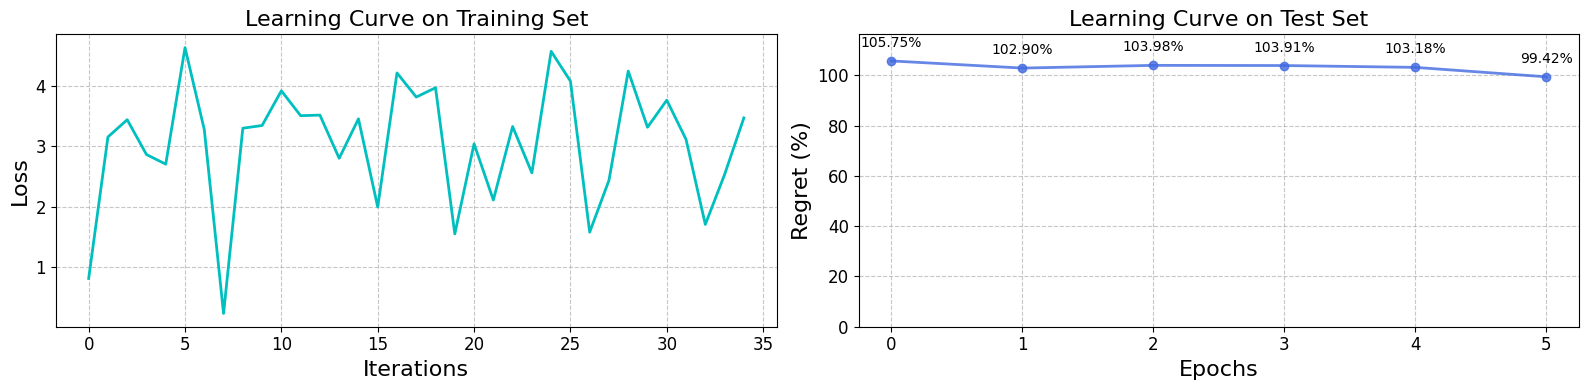

In [16]:

#############################################################################
# VISUALIZATION
#############################################################################
from matplotlib import pyplot as plt

def visLearningCurve(loss_log, loss_log_regret):
    """Enhanced visualization with smoother curves and more information"""
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    
    # Plot training loss with smoothing for readability
    n_points = len(loss_log)
    
    # Apply smoothing for large datasets
    if n_points > 100:
        window_size = max(10, n_points // 50)
        smoothed_loss = np.convolve(loss_log, np.ones(window_size)/window_size, mode='valid')
        x_axis = np.arange(len(smoothed_loss))
        ax1.plot(x_axis, smoothed_loss, color="c", lw=2, label=f"Smoothed (window={window_size})")
        # Also plot the raw data with transparency
        ax1.plot(loss_log, color="c", lw=0.5, alpha=0.3, label="Raw")
        ax1.legend()
    else:
        # For smaller datasets, just plot the raw data
        ax1.plot(loss_log, color="c", lw=2)
    
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iterations", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Draw plot for regret on test set
    epochs = np.arange(len(loss_log_regret))
    ax2.plot(epochs, [r*100 for r in loss_log_regret], 
             color="royalblue", marker='o', ls="-", alpha=0.8, lw=2)
    
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, max(50, max([r*100 for r in loss_log_regret])*1.1))  # Dynamic y-limit
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret (%)", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add values to points
    for i, r in enumerate(loss_log_regret):
        ax2.annotate(f"{r*100:.2f}%", 
                     (i, r*100),
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center')
    
    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    print("Saved learning curves to 'learning_curves.png'")
    plt.show()

print("\nVisualizing learning curves...")
visLearningCurve(loss_log, loss_log_regret)

# TODO

把MPAX里的变量绝对值约束条件也加上, 测试看看optDataset里解出来的sol是否正常；；  更进一步 考虑魔改 PyEPO里的MPAX代码，把covariance matrix的约束也加上

看SPO+ loss和gradient的math原理；然后在PyEPO的代码里也搞清楚这几个函数的互相嵌套关系

zyh-PyEPO/pkg/pyepo/metric/regret.py

zyh-PyEPO/pkg/pyepo/model/mpax/mpaxmodel.py

zyh-PyEPO/pkg/pyepo/func/surrogate.py

把optDataset也要做修改，要能load X的lag data，比如t-1, ..., t-L整个长度为L的time window的kline data，这个相对容易，因为下面的dataset.py里的self.feats是相对独立的，可以直接修改这个feats的读取方式

/home/yuheng/zyh-PyEPO/pkg/pyepo/data/dataset.py